### Loading Libraries 

In [2]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
import gif
#import scipy.misc.imresize
#.misc import imresize
# Unable to install scipy yet

% matplotlib inline
plt.style.use('ggplot')


### Settings 

In [12]:
# Activation settign
input_dimension = 2
output_dimension = 3;
no_neurons = 20;
n_iterations = 100;
batch_size = 500;
learning_rate = 0.001

### Flatten Function

In [4]:
def flatten(x, name=None, reuse=None):
    """Flatten Tensor to 2-dimensions.
    Parameters
    ----------
    x : tf.Tensor
        Input tensor to flatten.
    name : None, optional
        Variable scope for flatten operations
    Returns
    -------
    flattened : tf.Tensor
        Flattened tensor.
    """
    with tf.variable_scope('flatten'):
        dims = x.get_shape().as_list()
        if len(dims) == 4:
            flattened = tf.reshape(
                x,
                shape=[-1, dims[1] * dims[2] * dims[3]])
        elif len(dims) == 2 or len(dims) == 1:
            flattened = x
        else:
            raise ValueError('Expected n dimensions of 1, 2 or 4.  Found:',
                             len(dims))

        return flattened

### Function for Image Splitting

In [5]:
def split_image(img):
    # We'll first collect all the positions in the image in our list, xs
    xs = []

    # And the corresponding colors for each of these positions
    ys = []

    # Now loop over the image
    for row_i in range(img.shape[0]):
        for col_i in range(img.shape[1]):
            # And store the inputs
            xs.append([row_i, col_i])
            # And outputs that the network needs to learn to predict
            ys.append(img[row_i, col_i])

    # we'll convert our lists to arrays
    xs = np.array(xs)
    ys = np.array(ys)
    return xs, ys

### Function to Construct a Single Linear Fully Connected Layer

In [6]:
def linear(x, n_output, name=None, activation=None, reuse=None):
    """Fully connected layer.
    Parameters
    ----------
    x : tf.Tensor
        Input tensor to connect
    n_output : int
        Number of output neurons
    name : None, optional
        Scope to apply
    Returns
    -------
    op : tf.Tensor
        Output of fully connected layer.
    """
    if len(x.get_shape()) != 2:
        x = flatten(x, reuse=reuse)

    n_input = x.get_shape().as_list()[1]

    with tf.variable_scope(name or "fc", reuse=reuse):
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            dtype=tf.float32,
            initializer=tf.contrib.layers.xavier_initializer())

        b = tf.get_variable(
            name='b',
            shape=[n_output],
            dtype=tf.float32,
            initializer=tf.constant_initializer(0.0))

        h = tf.nn.bias_add(
            name='h',
            value=tf.matmul(x, W),
            bias=b)

        if activation:
            h = activation(h)

        return h, W

### Prepar the Data

[[ 0.90980393  0.90980393  0.87843138]
 [ 0.63529414  0.63137257  0.48235294]
 [ 0.51764709  0.51372552  0.32549021]
 ..., 
 [ 0.02352941  0.02745098  0.04313726]
 [ 0.24705882  0.25098041  0.26274511]
 [ 0.83529413  0.83529413  0.83529413]]


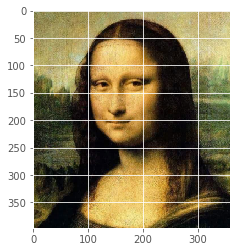

In [7]:
# Load the image 
img = plt.imread('art.png')
#img = imresize(img,(100, 100))
# Unable to install scipy

# Split 
xs, ys = split_image(img)


# Normalise 
xs = (xs - np.mean(xs, axis = 0)) / np.std(xs, axis =0)
#ys = ys / 255.0
# ys is already normalised for some unknow reason
print(ys)

plt.imshow(ys.reshape(img.shape))

### Reset Graph and Reload Data

In [8]:
# Reset
tf.reset_default_graph()

# inputs 
X =tf.placeholder(tf.float32, shape = [None, 2], name = 'X')

# outputs 
Y = tf.placeholder(tf.float32, shape = [None, 3], name = 'Y')

### Constrcut the Network 

In [9]:
h1, W1 = linear(X, no_neurons, activation = tf.nn.relu, name = 'layer1')
h2, W2 = linear(h1, no_neurons, activation = tf.nn.relu, name = 'layer2')
h3, W3 = linear(h2, no_neurons, activation = tf.nn.relu, name = 'layer3')
h4, W4 = linear(h3, no_neurons, activation = tf.nn.relu, name = 'layer4')
h5, W5 = linear(h4, no_neurons, activation = tf.nn.relu, name = 'layer5')
h6, W6 = linear(h5, no_neurons, activation = tf.nn.relu, name = 'layer6')
Y_pred, W7 = linear(h6, output_dimension, activation = None, name = 'layer_o')

### Define Error Function and Optimiser 

In [10]:
# Use l2 cost
cost = tf.reduce_mean(tf.reduce_sum(tf.squared_difference(Y, Y_pred),1))
# Adam optimiser 
optimiser = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### TensorBoard Logs


### Session 

Cost: 6.746010560738413e-05


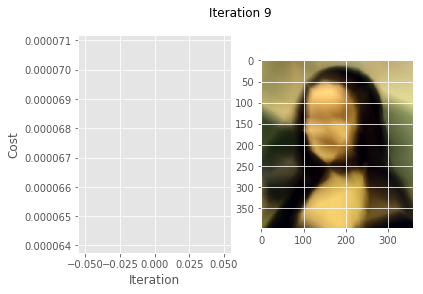

Cost: 5.750961340310281e-05


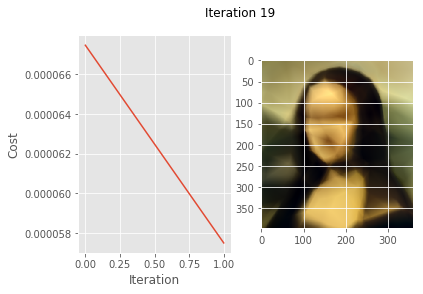

Cost: 5.9590403709495274e-05


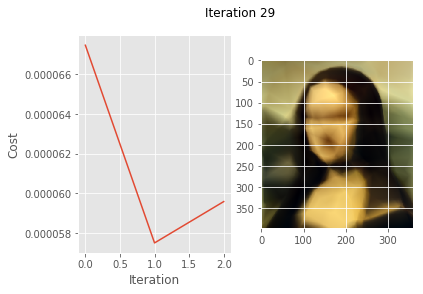

Cost: 6.733294249626628e-05


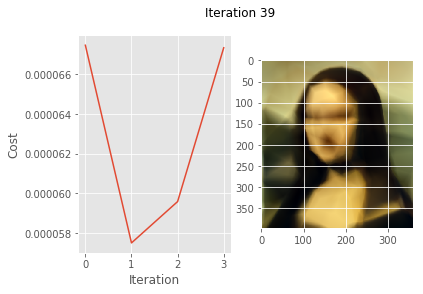

Cost: 5.65118891628165e-05


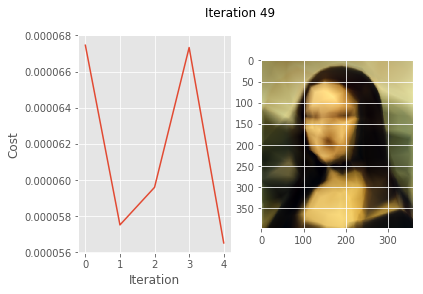

Cost: 5.999233639031126e-05


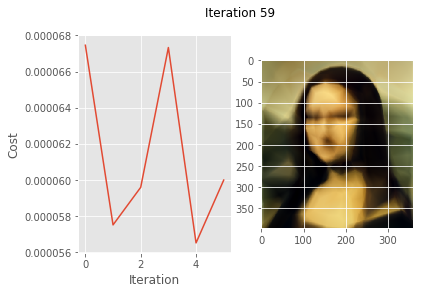

Cost: 4.1624619380423896e-05


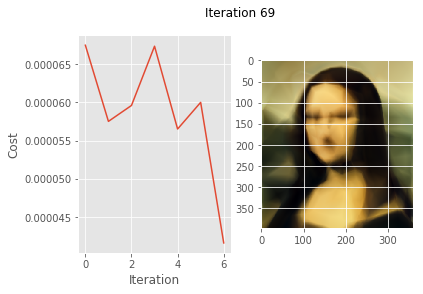

Cost: 4.84475800604151e-05


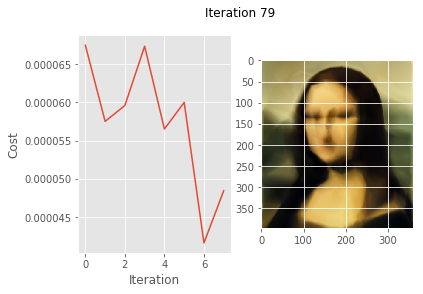

Cost: 4.696346688688847e-05


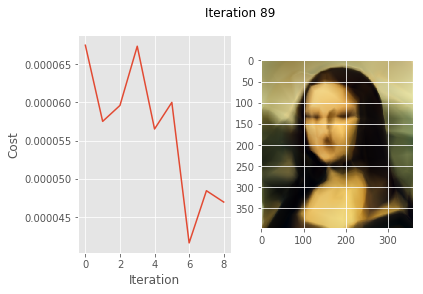

Cost: 5.407260175336871e-05


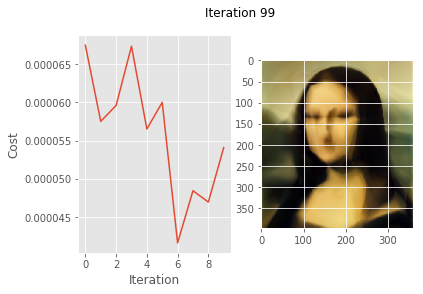

In [21]:
sess = tf.Session()

## TF Board 

# Initialize all your variables and run the operation with your session
sess.run(tf.global_variables_initializer())

# Optimize over a few iterations, each time following the gradient
# a little at a time
imgs = []
costs = []
gif_step = n_iterations // 10
step_i = 0

# Saver
saver = tf.train.Saver()
#Writer
writer = tf.summary.FileWriter("./tmp/logs/1")
writer.add_graph(sess.graph)

for it_i in range(n_iterations):
    
    # Get a random sampling of the dataset
    idxs = np.random.permutation(range(len(xs)))
    
    # The number of batches we have to iterate over
    n_batches = len(idxs) // batch_size
    
    # Now iterate over our stochastic minibatches:
    for batch_i in range(n_batches):
         
        # Get just minibatch amount of data
        idxs_i = idxs[batch_i * batch_size: (batch_i + 1) * batch_size]

        # And optimize, also returning the cost so we can monitor
        # how our optimization is doing.
        training_cost = sess.run(
            [cost, optimiser],
            feed_dict={X: xs[idxs_i], Y: ys[idxs_i]})[0]

    # Also, every 20 iterations, we'll draw the prediction of our
    # input xs, which should try to recreate our image!
    if (it_i + 1) % gif_step == 0:
        costs.append(training_cost / n_batches)
        ys_pred = Y_pred.eval(feed_dict={X: xs}, session=sess)
        img = np.clip(ys_pred.reshape(img.shape), 0, 1)
        imgs.append(img)
        # Plot the cost over time
        print('Cost: {}' .format(costs[-1]))

        
        fig, ax = plt.subplots(1, 2)
        ax[0].plot(costs)
        ax[0].set_xlabel('Iteration')
        ax[0].set_ylabel('Cost')
        ax[1].imshow(img)
        fig.suptitle('Iteration {}'.format(it_i))
        plt.show()



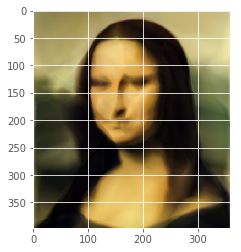

In [20]:
# Save the images as a GIF
'''
_ = gif.build_gif(imgs, saveto='single.gif', show_gif=False)
ipyd.Image(url='single.gif?{}'.format(np.random.rand()),
           height=500, width=500)
'''

plt.imshow(img)
## Save the model 

filename = saver.save(sess, './tmp/my_model', global_step=n_iterations)


